                                      Computer Vision – II prova in itinere 
                                            Corsaro Salvatore 1000012453
                                                 a.a 2019/2020
                                                             
                                                
                                
# Stitching

Lo stitching di immagini è un metodo col quale dato in input un gruppo di immagini genererà in output un’immagine composita tale da costruire scene di immagini, preservando il flusso logico tra le immagini. È importante notare che le immagini devono condividere alcune aree comuni. Quindi da un gruppo di queste immagini, possiamo creare una singola immagine cucita, che spiega in dettaglio l'intera scena.


# Goals

In questo tutorial viene descritto come eseguire lo stitching di immagini e la costruzione di immagini “panorama” usando Python e OpenCV. Date in input due immagini, le "ricuciremo" insieme per creare un panorama semplice. Per costruire il nostro panorama delle immagini, utilizzeremo tecniche di computer vision e di image processing come: 

•	Rilevazione di punti chiave

•	Descrittori invarianti locali (SIFT, SURF, ecc.)

•	Corrispondenza delle features

•	Stima dell'omografia usando RANSAC

•	Deformazione prospettica

Infine, unire i risultati ottenuti

# Processing
Per il nostro tutorial utilizzeremo una bellissima foto della cattedrale di Budapest, che divideremo in due parti(destra e  sinistra)con aeree in comune, e proveremo a recuperare la foto panoramica intera. Dividendo questa immagine in due immagini avremo quindi una sorta di regione di sovrapposizione. Inoltre occorre importare i pacchetti necessari per lo sviluppo del nostro algoritmo


In [14]:
# import the necessary packages
import cv2
import numpy as np
import matplotlib.pyplot as plt
import imageio
import imutils
cv2.ocl.setUseOpenCL(False)

# load the two images
imageA = imageio.imread("images/sx2.jpg")
imageB = imageio.imread("images/dx2.jpg")

# Rilevamento ed estrazione delle features

La prima fase prevede l’estrazione di alcuni punti chiave e feature di interesse che permettono di avere una soluzione più robusta quando le immagini presentano delle differenze nei seguenti aspetti: spacial position, angle, scaling, capturing device. 

### Rilevamento di punti chiave
Possiamo pensare banalmente di estrarre punti chiave usando un algoritmo come "Harris Corners", per poi fare il matching dei punti chiave corrispondenti sulla base di una certa somiglianza come la distanza euclidea. Come sappiamo gli angoli sono invarianti alla rotazione e quindi, una volta rilevato un angolo, anche se ruotiamo un'immagine, quell'angolo si troverà sempre allo stesso punto.
Tuttavia, se ruotiamo e ridimensioniamo un'immagine avremmo difficoltà perché gli angoli non sono invarianti allo scaling, e l'angolo precedentemente rilevato potrebbe diventare una linea. Questo perché gli algoritmi del rivelatore di angoli utilizzano un kernel di dimensioni fisse per rilevare regioni di interesse (angoli) sulle immagini, e quindi quando ridimensioniamo un'immagine, questo kernel potrebbe diventare troppo piccolo o troppo grande.

Dunque, abbiamo bisogno di features invarianti alla rotazione e al ridimensionamento.
Proprio per ovviare questo problema introduciamo metodi più efficienti come SIFT, SURF e ORB.
Questi ultimi usano Difference of Gaussians (DoD). L'idea è di applicare DoD su versioni in scala diversa della stessa immagine. Utilizza inoltre le informazioni sui pixel adiacenti per trovare e perfezionare i punti chiave e i descrittori corrispondenti.

Per iniziare, dobbiamo caricare 2 immagini, un'immagine di query e un'immagine di addestramento. Inizialmente, occorre estrarre i punti chiave e i descrittori invarianti locali da entrambi. Possiamo farlo in un solo passaggio utilizzando la funzione OpenCV "detectAndCompute ()" .Per un corretto utilizzo di detectAndCompute () è necessaria un'istanza di un rilevatore di punti chiave e di un descrittore di invarianti locali che può essere ORB, SIFT o SURF, ecc. Inoltre, prima di passare le immagini in detectAndCompute () occorre convertirle in scala di grigi.
Se si sceglie sift e appare un errore del tipo:module 'cv2' has no attribute 'SIFT_create' questo succede perchè SIFT è un algoritmo brevettato, quindi non disponibile in ogni versione open-cv. Quello che puoi fare è installare contemporaneamente opencv e la sua parte contrib. 

"pip install opencv-python==3.3.0.10 opencv-contrib-python==3.3.0.10"

In [15]:
# seleziona l'id dell'immagine per identificare il descrittore di caratteristiche
# scegli uno di questi:'sift', 'brisk', 'orb', 'surf'
f_extractor = 'brisk' 
#f_extractor = 'sift' 
f_matching = 'bf'

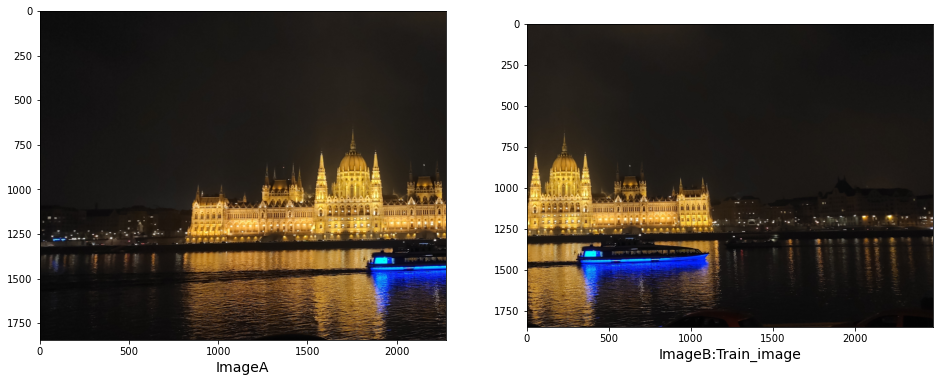

In [16]:
# trasformiamo le immagini in scale di grigio
#selezioniamo una delle due immagini come train, ed eseguiamo le trasformazioni
trainImg_gray = cv2.cvtColor(imageB, cv2.COLOR_RGB2GRAY)

# Opencv defines the color channel in the order BGR. 
# Transform it to RGB to be compatible to matplotlib
queryImg_gray = cv2.cvtColor(imageA, cv2.COLOR_RGB2GRAY)

fig, (a1, a2) = plt.subplots(nrows=1, ncols=2, constrained_layout=False, figsize=(16,9))
a1.imshow(imageA, cmap="gray")
a1.set_xlabel("ImageA", fontsize=14)

a2.imshow(imageB, cmap="gray")
a2.set_xlabel("ImageB:Train_image", fontsize=14)

plt.show()

In [17]:
def detectAndDescribe(image, method=None):
    """
    Compute key points and feature descriptors using an specific method
    """
    
    assert method is not None, "You need to define a feature detection method. Values are: 'sift', 'surf'"
    
    # detect and extract features from the image
    if method == 'sift':
        descriptor = cv2.xfeatures2d.SIFT()
    elif method == 'surf':
        descriptor = cv2.SURF_create()
    elif method == 'brisk':
        descriptor = cv2.BRISK_create()
    elif method == 'orb':
        descriptor = cv2.ORB_create()
        
    # get keypoints and descriptors
    (kps, features) = descriptor.detectAndCompute(image, None)
    
    return (kps, features)

Una volta eseguito detectAndCompute (), sia sulla queryImage e sia sulla TrainImgage, otteniamo una serie di punti chiave e descrittori per entrambe le immagini. Se utilizziamo SIFT come estrattore di feature, restituisce un vettore di feature a 128 dimensioni per ciascun punto chiave. Se si sceglie SURF, otteniamo un vettore di feature a 64 dimensioni. Le immagini seguenti mostrano alcune delle funzionalità estratte usando uno tra BRISK, ORB, SIFT e SURF.


In [18]:
#kp1 e kp2 sono punti chiave, des1 e des2 sono i descrittori delle rispettive immagini.
kp1, des1 = detectAndDescribe(trainImg_gray, method=f_extractor)
kp2, des2 = detectAndDescribe(queryImg_gray, method=f_extractor)

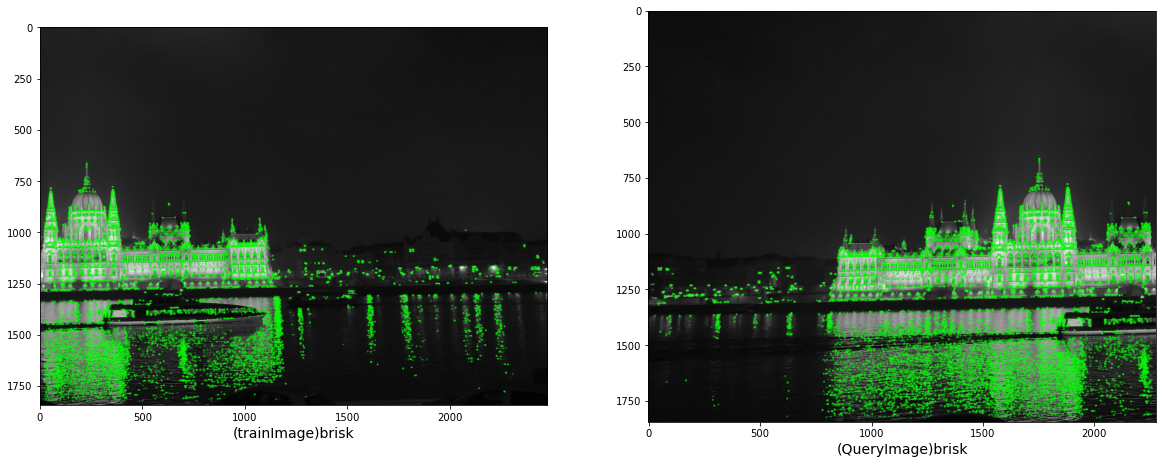

In [19]:
# visualizza i punti chiave e le caratteristiche rilevate precedentemente su entrambe le immagini
fig, (a1,a2) = plt.subplots(nrows=1, ncols=2, figsize=(20,8), constrained_layout=False)
a1.imshow(cv2.drawKeypoints(trainImg_gray,kp1,None,color=(0,255,0)))
a1.set_xlabel("(trainImage)"+f_extractor, fontsize=14)
a2.imshow(cv2.drawKeypoints(queryImg_gray,kp2,None,color=(0,255,0)))
a2.set_xlabel("(QueryImage)"+f_extractor, fontsize=14)

plt.show()

In questo modo abbiamo ottenuto i descrittori e i punti chiave di due immagini, così da poter trovare le corrispondenze tra le due immagini, poichè per unire due immagini qualsiasi in immagini più grandi, dobbiamo trovare i punti sovrapposti. 

Tali punti sovrapposti ci forniscono molte informazioni:

• l'orientamento della seconda immagine rispetto alla prima;

• differenze di dimensioni tra le immagini

• se un'immagine è stata ruotata e quindi sovrapposta

• se un'immagine è stata ridimensionata e poi adattata.


# Corrispondenze delle features

Una volta ottenuti tali informazioni, possiamo procedere con il confrontare i 2 set di features e ricercare le coppie che mostrano più somiglianza.
La corrispondenza delle features in OpenCV si può eseguire in due modi:
• FLANN o KNN (k-vicini più vicini)
• Brute Force Matcher
entrambi i metodi richiedono un oggetto matcher.

#### FLANN
FLANN è l'acronimo di Fast Library for Approximate Nearest Neighbors è Contiene una raccolta di algoritmi ottimizzati per la ricerca rapida del vicino più vicino in set di dati di grandi dimensioni e per funzionalità ad alta dimensione. Funziona più velocemente di BFMatcher per set di dati di grandi dimensioni. Per il suo utilizzo dobbiamo passare due dizionari che specificano l'algoritmo da utilizzare, i relativi parametri, ecc. Il primo è IndexParams. 
Per assicurarsi che le funzionalità restituite da KNN siano ben comparabili, gli autori del documento SIFT, suggeriscono una tecnica chiamata "test del rapporto" . Fondamentalmente, ripetiamo su ciascuna delle coppie restituite da KNN ed eseguiamo un test a distanza. Per ogni coppia di funzioni ( f1, f2 ), se la distanza tra f1 e f2 è entro un certo rapporto, la manteniamo, altrimenti la gettiamo via, assicurando che un paio di funzioni rilevate siano effettivamente abbastanza vicine da essere considerate simili. Inoltre, il valore del rapporto deve essere scelto manualmente.

#### Bruteforce Matcher
Il Matcher BruteForce (BF) fa esattamente ciò che suggerisce il suo nome. Dati 2 set di features (A e B), ciascuna feature dell'insieme A viene confrontata con tutte le features dell'insieme B, calcolando la distanza euclidea o la distanza di Hamming tra due punti e restituendo quindi la feature più vicina dal set di features di B.
OpenCV consiglia di utilizzare la distanza euclidea per SIFT e SURF, mentre la distanza di Hamming per ORB e BRISK.

Per creare un Matcher BruteForce usando OpenCV, dobbiamo solo specificare 2 parametri. La prima è la metrica della distanza. Il secondo è il parametro booleano crossCheck .

In [20]:
def createMatcher(method,crossCheck):
    #crea e restituisce un oggetto matcher
    
    if method == 'sift' or method == 'surf':
        bf = cv2.BFMatcher(cv2.NORM_L2, crossCheck=crossCheck)
    elif method == 'orb' or method == 'brisk':
        bf = cv2.BFMatcher(cv2.NORM_HAMMING, crossCheck=crossCheck)
    return bf

In [21]:
# Bruteforce Matcher
def matchKeyPointsBF(featuresA, featuresB, method):
    bf = createMatcher(method, crossCheck=True)
        
    # Match descriptors.
    best_matches = bf.match(featuresA,featuresB)
    
    # Ordina le features in ordine di distanza.
    # I punti con più somiglianza, ovvero con minor distanza sono ordinati per primi nel vettore
    rawMatches = sorted(best_matches, key = lambda x:x.distance)
    print("Raw matches (Brute force):", len(rawMatches))
    return rawMatches

Il parametro crossCheck bool indica che le due funzionalità devono corrispondere tra loro per essere considerate valide. Nel senso che, affinché una coppia di funzioni ( f1, f2 ) sia considerata idonea, f1 deve corrispondere a f2 e f2 deve corrispondere anche a f1 come corrispondenza più vicina. Tale procedura permette di avere un set più robusto di funzioni corrispondenti ed è descritta nella procedura SIFT originale.
Tuttavia, se vogliamo prendere in considerazione più di una corrispondenza candidata, utilizziamo una procedura di corrispondenza basata su FLANN.

In [22]:
    # FLANN matcher
def matchKeyPointsKNN(featuresA, featuresB, ratio, method):
        bf = createMatcher(method, crossCheck=False)
        # calcola le corrispondenze non elaborate e inizializza l'elenco delle corrispondenze effettive
        rawMatches = bf.knnMatch(featuresA, featuresB, 2)
        print("Raw matches (knn):", len(rawMatches))
        matches = []

        # loop sulle corrispondenze
        for m,n in rawMatches:
            # condizione che assicurara che la distanza sia entro un certo range
            if m.distance < n.distance * ratio:
                matches.append(m)
        return matches

Using: bf feature matcher
Raw matches (Brute force): 10937


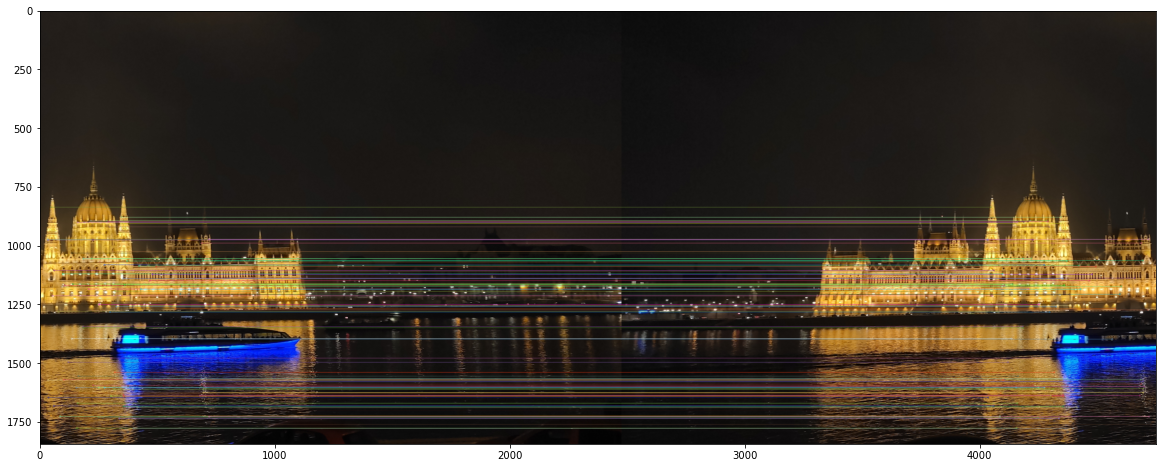

In [23]:
print("Using: {} feature matcher".format(f_matching))

fig = plt.figure(figsize=(20,8))

if f_matching == 'bf':
    matches = matchKeyPointsBF(des1, des2, method=f_extractor)
    img3 = cv2.drawMatches(imageB,kp1,imageA,kp2,matches[:100],
                           None,flags=cv2.DrawMatchesFlags_NOT_DRAW_SINGLE_POINTS)
elif f_matching == 'knn':
    matches = matchKeyPointsKNN(des1, des2, ratio=0.75, method=f_extractor)
    img3 = cv2.drawMatches(imageB,kp1,imageA,kp2,np.random.choice(matches,100),
                           None,flags=cv2.DrawMatchesFlags_NOT_DRAW_SINGLE_POINTS)
    

plt.imshow(img3)
plt.show()

# Homografy

Una volta ottenute le migliori corrispondenze tra le immagini, il nostro prossimo passo è quello di prendere questi punti e trovare la matrice di trasformazione che unirà le 2 immagini in base ai loro punti di corrispondenza.
Tale trasformazione è chiamata matrice dell'omografia. L'omografia è una matrice 3x3 che può essere utilizzata in molte applicazioni come la stima della posa della telecamera, la correzione della prospettiva e il punto dell'immagine, ed è una trasformazione 2D, ovvero mappa i punti da un piano (immagine) ad un altro.

### Stima dell'omografia usando RANSAC
RANdom SAmple Consensus o RANSAC è un algoritmo iterativo per adattarsi a modelli lineari. Diversamente dagli altri regressori lineari che utilizzano la stima dei minimi quadrati per adattare il modello migliore ai dati ma sensibili ai valori anomali, RANSAC è progettato per essere performante per valori anomali, stimando i parametri utilizzando solo un sottoinsieme di "inliers" nei dati, tracciando una linea retta dal punto chiave N nella prima immagine al punto chiave M nella seconda immagine. Pertanto, è importante disporre di un algoritmo (RANSAC) in grado di filtrare i punti che appartengono chiaramente alla distribuzione dei dati da quelli che non lo fanno.

In [24]:
def getHomography(kp1, kp2, des1, des2, matches, reprojThresh):
    # converte i punti chiave in numpy arrays
    kp1 = np.float32([kp.pt for kp in kp1])
    kp2 = np.float32([kp.pt for kp in kp2])
    
    if len(matches) > 4:

        # costruzione dei due set di punti
        ptsA = np.float32([kp1[m.queryIdx] for m in matches])
        ptsB = np.float32([kp2[m.trainIdx] for m in matches])
        
        # stimare l'omografia tra le serie di punti
        (H, status) = cv2.findHomography(ptsA, ptsB, cv2.RANSAC,
            reprojThresh)

        return (matches, H, status)
    else:
        return None

In [25]:
M = getHomography(kp1, kp2, des1, des2, matches, reprojThresh=4)
if M is None:
    print("Error!")
(matches, H, status) = M
print(H)

[[ 9.98792846e-01 -5.82837345e-04  1.52486018e+03]
 [-3.52660781e-04  9.99084985e-01  6.39209153e-01]
 [-2.95700637e-07 -3.04865771e-07  1.00000000e+00]]


# Deformazione prospettica

Una volta ottenuta l'omografia stimata, dobbiamo deformare una delle immagini su un piano comune.
La trasformazione prospettica può combinare una o più operazioni come rotazione, scala, traslazione o taglio. L'idea è di trasformare una delle immagini in modo che entrambe le immagini si fondano come una. Per fare ciò, possiamo usare la funzione warpPerspective () di OpenCV . Prende un'immagine e l'omografia come input, e deforma l'immagine sorgente verso la destinazione in base all'omografia.


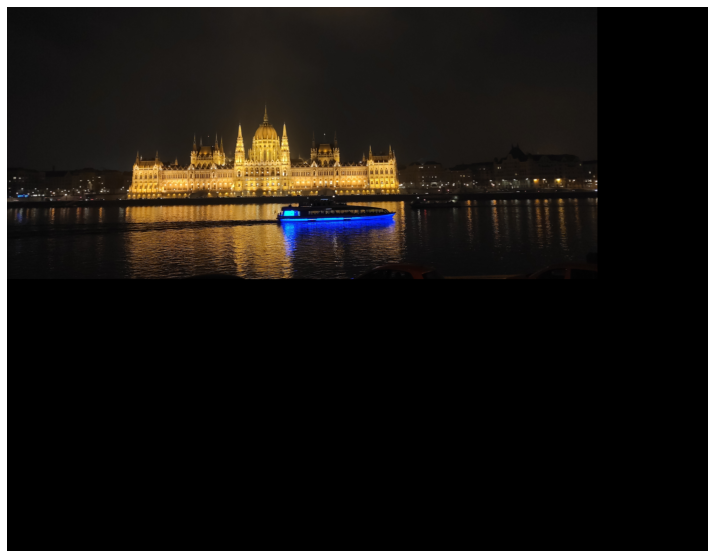

In [26]:
# Applichiamo la deformazione prospettica creando una correzione "panorama"
width = imageB.shape[1] + imageA.shape[1]
height = imageB.shape[0] + imageA.shape[0]

#H sta per Homografy
result = cv2.warpPerspective(imageB, H, (width, height))
result[0:imageA.shape[0], 0:imageA.shape[1]] = imageA

plt.figure(figsize=(20,10))
plt.imshow(result)

plt.axis('off')
plt.show()

# Conclusioni

In questo  tutorial viene spiegato come eseguire lo stitching di immagini e la costruzione di panorami usando OpenCV.
Abbbiamo visto come lo stitching delle immagini richiede quattro passaggi principali: rilevamento dei punti chiave ed estrazione di descrittori invarianti locali; ottenere descrittori corrispondenti tra le immagini; applicare RANSAC per stimare la matrice di omografia; applicare una trasformazione deformante usando la matrice di omografia.
In conclusione possiamo dire che questo algoritmo funziona in pratica quando si costruiscono panorami solo per due immagini.